# Which phenometrics are most responsible for overall productivity trends?

Partial correlations between the Integral of Season (area under seasonal growth curve) and phenometrics

In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import os
import sys
import math
import pickle
import warnings
import distinctipy
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as ctx
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
# from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch


import shap
# from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score #mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import pingouin as pg

## Analysis Parameters


In [2]:
product='AusENDVI-clim_MCD43A4'
base = '/g/data/os22/chad_tmp/Aus_phenology/'
ds_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022.nc'
timeseries_file =f'{base}data/pickle/IBRA_subregions_climate.pkl'
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'
phenometrics_file = f'{base}data/pickle/IBRA_subregions_{product}_phenometrics.pkl'

## Open climate timeseries and phenometrics

In [3]:
with open(phenometrics_file, 'rb') as f:
    phenometrics = pickle.load(f)

#open ecoregions
gdf = gpd.read_file(ecoregions_file)

#remove regions we dropped
gdf = gdf[gdf['SUB_NAME_7'].isin(list(phenometrics.keys()))]

## Test partial correlations

In [ ]:
# phenometrics['Warre'][['IOS','vPOS','vSOS','vEOS','vTOS','SOS','POS','EOS','LOS','AOS']].rolling(5).mean().plot(subplots=True, layout=(2,5), figsize=(16,6));
# p_corr = pg.pairwise_corr(phenometrics['Mitchell'].rolling(10).mean(),
#                  columns=[['IOS'],['vPOS','vSOS','vEOS','vTOS','SOS','POS','EOS','LOS','AOS']]) 
# p_corr

In [ ]:
# df = phenometrics['Mitchell'].rolling(5).mean().dropna()
# x = df[['vPOS','vSOS','vEOS','vTOS','SOS','POS','EOS','LOS','AOS']]
# y = df['IOS']

# rf = RandomForestRegressor(n_estimators=100).fit(x, y)
# prediction = rf.predict(x)
# r2 = r2_score(y, prediction)
# print(r2)

# explainer = shap.Explainer(rf)
# shap_values = explainer(x)

# fig, ax = plt.subplots(1,1, figsize=(5,7))
# shap.plots.bar(shap_values, max_display=10, show=True)

## Partial correlation over IBRA regions

In [9]:
dffs_corr = []
dffs_shap = []
for region,v in phenometrics.items():

    #resample to remove IAV
    df = phenometrics[region].rolling(5).mean().dropna()
    
    # df['time'] = [datetime.strptime(f'{int(y)} {int(doy)}', '%Y %j') for y,doy in zip(df['POS_year'], df['POS'])]
    # df = df.set_index('time').resample('3YE').mean()

    
    # Partial correlation -----------------
    p_corr = pg.pairwise_corr(df,
                 columns=[['IOS'],['vPOS','vSOS','vEOS','SOS','POS','EOS']]) 

    p_corr_clean = p_corr[['Y','r']].set_index('Y').transpose().reset_index(drop=True)
    p_corr_clean['SUB_NAME_7'] = region
    
    highest_corr = p_corr[['Y','r']].set_index('Y').abs().idxmax().values.item()
    p_corr_clean['highest_corr'] = highest_corr

    dffs_corr.append(p_corr_clean)

    # -------ML SHAP values ---------------------
    x = df[['vPOS','vSOS','vEOS','SOS','POS','EOS']]
    y = df['IOS']
    
    rf = RandomForestRegressor(n_estimators=100, random_state = 1).fit(x, y)
    prediction = rf.predict(x)
    explainer = shap.Explainer(rf)
    shap_values = explainer(x)
    
    vals = np.abs(shap_values.values).mean(0)
    fi = pd.DataFrame(list(zip(x.columns, vals)), columns=['col_name','feature_importance_vals'])
    fi.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
    
    fi_clean = fi.set_index('col_name').transpose().reset_index(drop=True)
    fi_clean['SUB_NAME_7'] = region
    
    highest_shap = fi[['col_name','feature_importance_vals']].set_index('col_name').abs().idxmax().values.item()
    fi_clean['highest_shap'] = highest_shap
    
    dffs_shap.append(fi_clean)

gdf_with_corrs = gdf.merge(pd.concat(dffs_corr), on='SUB_NAME_7')
gdf_with_shap = gdf.merge(pd.concat(dffs_shap), on='SUB_NAME_7')

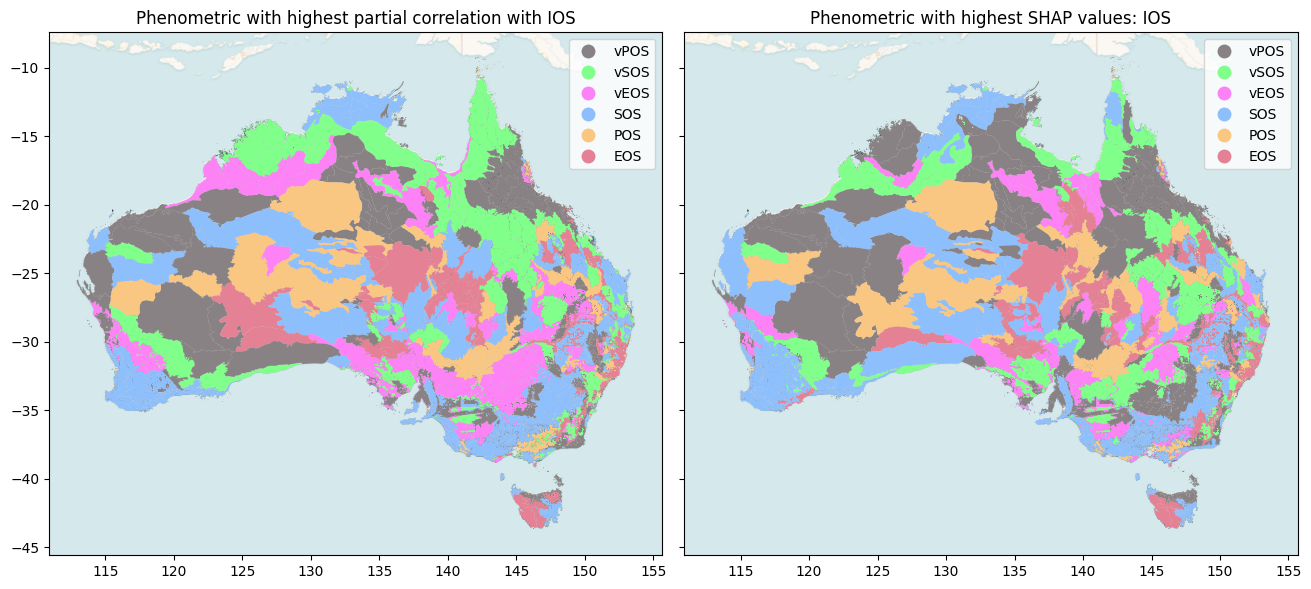

In [10]:
fig,ax=plt.subplots(1,2, figsize=(13,6), sharey=True, layout='constrained')

categories = ['vPOS','vSOS','vEOS','SOS','POS','EOS']
colors = distinctipy.get_colors(len(categories), pastel_factor=1)
cmap = LinearSegmentedColormap.from_list("cwc", colors, N=len(categories))


gdf_with_corrs.plot(edgecolor="black", linewidth=0.05,facecolor='none', ax=ax[0])
a = gdf_with_corrs.plot(column='highest_corr', ax=ax[0], legend=True, cmap=cmap,
                        categories=categories)
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1);
ax[0].set_title('Phenometric with highest partial correlation with IOS')

gdf_with_corrs.plot(edgecolor="black", linewidth=0.05,facecolor='none', ax=ax[1])
a = gdf_with_shap.plot(column='highest_shap', ax=ax[1],legend=True, cmap=cmap,
                       categories=categories)
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1);
ax[1].set_title('Phenometric with highest SHAP values: IOS');